In [1]:
import os
import shutil
import random

# Source directory
source_dir = "New Folder"
# Destination base directory
base_dest = "dataset"

# Labels/folders to process
labels = ['!', '(', ')', '[', ']', '{', '}', 'pi','sqrt']

# Train/Test split
split_ratio = 0.8

# Create dataset/train and dataset/test directories and their subdirectories
for split in ['train', 'test']:
    for label in labels:
        os.makedirs(os.path.join(base_dest, split, label), exist_ok=True)

# Move and split data
for label in labels:
    label_source_path = os.path.join(source_dir, label)
    images = os.listdir(label_source_path)
    images = [img for img in images if os.path.isfile(os.path.join(label_source_path, img))]

    random.shuffle(images)
    split_point = int(len(images) * split_ratio)
    train_images = images[:split_point]
    test_images = images[split_point:]

    for img in train_images:
        src = os.path.join(label_source_path, img)
        dst = os.path.join(base_dest, 'train', label, img)
        shutil.copy2(src, dst)

    for img in test_images:
        src = os.path.join(label_source_path, img)
        dst = os.path.join(base_dest, 'test', label, img)
        shutil.copy2(src, dst)

print("Dataset has been split and copied successfully.")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'New Folder\\!'

## preprocess others

In [4]:
import cv2
import os
import numpy as np

# Define paths
input_base = "dataset"  # Original dataset folder
output_base = "SymbolDataset"  # New preprocessed dataset folder

categories = ['!', '(', ')', '[', ']', '{', '}', 'pi', 'sqrt']
subsets = ["train", "test"]

# Create output directory structure
for subset in subsets:
    for category in categories:
        os.makedirs(os.path.join(output_base, subset, category), exist_ok=True)

def preprocess_image(image_path):
    """ Preprocess image to 28x28 format """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Couldn't read image {image_path}")
        return None

    # Apply binary thresholding
    _, binary = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY_INV)

    # Find bounding box
    y_indices, x_indices = np.where(binary > 0)
    if len(y_indices) > 0 and len(x_indices) > 0:
        x_min, x_max = x_indices.min(), x_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()
        cropped = binary[y_min:y_max+1, x_min:x_max+1]
    else:
        return None  # Skip empty images

    # Resize while maintaining aspect ratio
    h, w = cropped.shape
    if h == 0 or w == 0:
        return None
    aspect_ratio = w / h
    if aspect_ratio > 1:
        new_w = 20
        new_h = max(1, int(20 / aspect_ratio))
    else:
        new_h = 20
        new_w = max(1, int(20 * aspect_ratio))

    resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Center in 28x28 black background
    final_img = np.zeros((28, 28), dtype=np.uint8)
    x_offset = (28 - new_w) // 2
    y_offset = (28 - new_h) // 2
    final_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    return final_img

# Process all images
for subset in subsets:
    for category in categories:
        input_folder = os.path.join(input_base, subset, category)
        output_folder = os.path.join(output_base, subset, category)

        for img_name in os.listdir(input_folder):
            img_path = os.path.join(input_folder, img_name)
            processed_img = preprocess_image(img_path)

            if processed_img is not None:
                output_path = os.path.join(output_folder, img_name)
                cv2.imwrite(output_path, processed_img)
            else:
                print(f"Skipped: {img_path}")

print("Preprocessing complete. Images saved in 'SymbolDataset'.")


Preprocessing complete. Images saved in 'SymbolDataset'.


# Final model

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Load and Preprocess MNIST Dataset

In [2]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

# Normalize MNIST images
X_train_mnist, X_test_mnist = X_train_mnist / 255.0, X_test_mnist / 255.0

# Reshape for CNN
X_train_mnist = X_train_mnist.reshape(-1, 28, 28, 1)
X_test_mnist = X_test_mnist.reshape(-1, 28, 28, 1)

## Load and Preprocess Operator Dataset

In [3]:
operator_base_path = "SymbolDataset"
operator_labels = ["add", "subtract", "multiply", "divide", "!", "(", ")", "[", "]", "{", "}", "pi", "sqrt"]
operator_to_label = {op: i+10 for i, op in enumerate(operator_labels)}  

def load_operator_dataset(split):
    images = []
    labels = []
    folder_path = os.path.join(operator_base_path, split)

    for label in operator_labels:
        class_path = os.path.join(folder_path, label)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28)) / 255.0  # Normalize
            images.append(img.reshape(28, 28, 1))
            labels.append(operator_to_label[label])

    return np.array(images), np.array(labels)

X_train_op, y_train_op = load_operator_dataset("train")
X_test_op, y_test_op = load_operator_dataset("test")

## Combine dataset

In [6]:
X_train = np.concatenate((X_train_mnist, X_train_op), axis=0)
y_train = np.concatenate((y_train_mnist, y_train_op), axis=0)

X_test = np.concatenate((X_test_mnist, X_test_op), axis=0)
y_test = np.concatenate((y_test_mnist, y_test_op), axis=0)

y_train = to_categorical(y_train, num_classes=23)
y_test = to_categorical(y_test, num_classes=23)


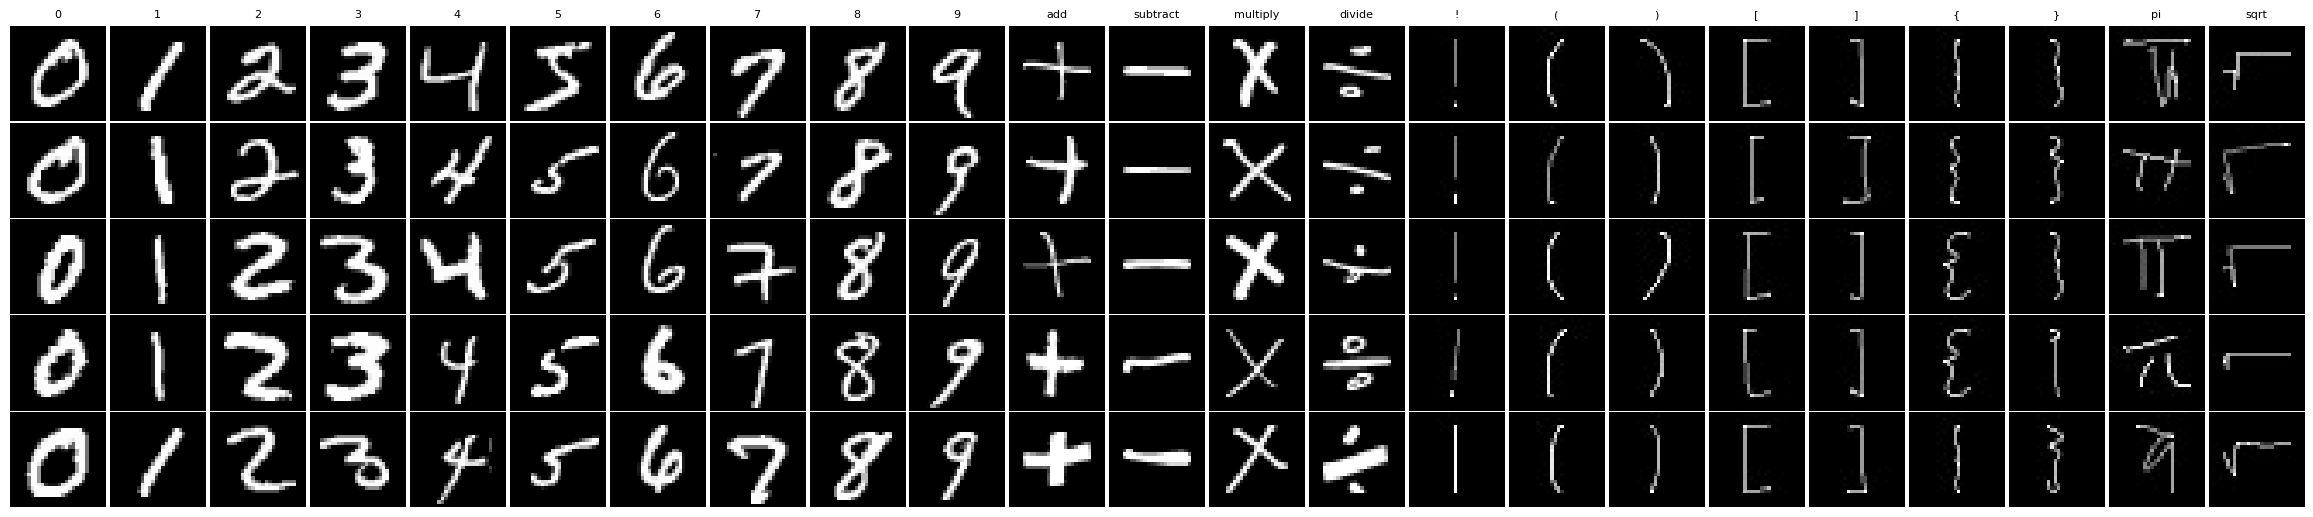

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Combine images and labels for easy access
combined_images = np.concatenate((X_train, X_test), axis=0)
combined_labels = np.concatenate((np.argmax(y_train, axis=1), np.argmax(y_test, axis=1)), axis=0)

# Class names: 0-9 digits + operator labels
class_names = [str(i) for i in range(10)] + operator_labels

# Track how many samples have been plotted for each class
samples_per_class = {i: 0 for i in range(23)}
max_samples = 5

# Prepare storage for plotting order: 5 rows x 23 columns
class_columns = [[] for _ in range(23)]

for i in range(len(combined_images)):
    label = combined_labels[i]
    if samples_per_class[label] < max_samples:
        class_columns[label].append(combined_images[i])
        samples_per_class[label] += 1
    if all(count == max_samples for count in samples_per_class.values()):
        break

# Set up the figure
fig, axes = plt.subplots(nrows=max_samples, ncols=23, figsize=(23, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Plot the images: each column corresponds to a class
for col in range(23):
    for row in range(max_samples):
        ax = axes[row, col]
        ax.imshow(class_columns[col][row].reshape(28, 28), cmap='gray')
        ax.axis('off')
        # Only set title on the top row
        if row == 0:
            ax.set_title(class_names[col], fontsize=8)

plt.tight_layout(pad=0.1)
plt.show()


## Using ADAM optimizer without validation

In [16]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3), 
    Dense(64, activation='relu'),
    Dropout(0.3), 
    Dense(23, activation='softmax')
])

D:\Sem - 6\Minor 2\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [18]:
history = model.fit(X_train, y_train, epochs=8, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/8
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.8255 - loss: 0.6266 - val_accuracy: 0.9815 - val_loss: 0.0605
Epoch 2/8
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.9690 - loss: 0.1119 - val_accuracy: 0.9877 - val_loss: 0.0387
Epoch 3/8
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - accuracy: 0.9794 - loss: 0.0739 - val_accuracy: 0.9911 - val_loss: 0.0273
Epoch 4/8
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9845 - loss: 0.0558 - val_accuracy: 0.9914 - val_loss: 0.0301
Epoch 5/8
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9868 - loss: 0.0461 - val_accuracy: 0.9920 - val_loss: 0.0270
Epoch 6/8
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9884 - loss: 0.0393 - val_accuracy: 0.9925 - val_loss: 0.0236
Epoch 7/8
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9891 - loss: 0.0383 - val_accuracy: 0.9935 - val_loss: 0.0234
Epoch 8/8
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9907 - loss: 0.0318

In [33]:
test_loss, test_acc = model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

656/656 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9906 - loss: 0.0311

Test Accuracy: 99.28%


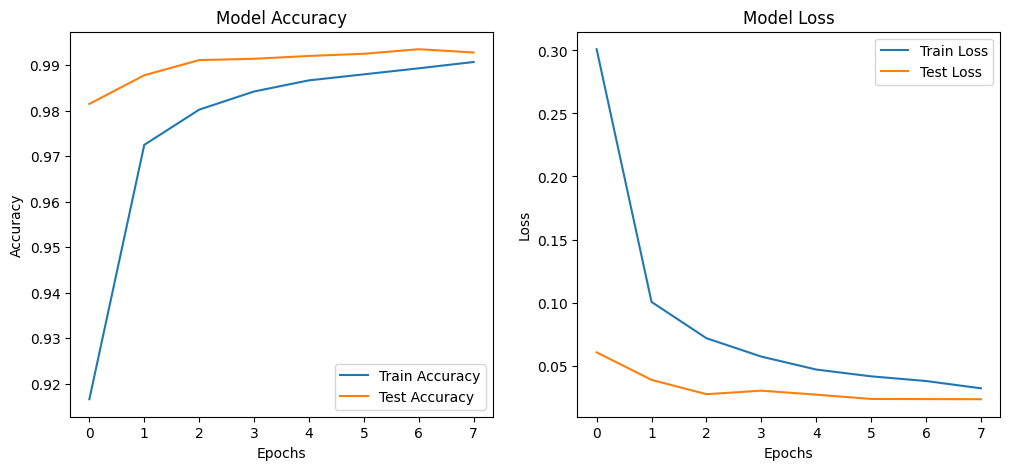

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [21]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(10)] + operator_labels))

656/656 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009
         add       0.99      1.00      0.99       533
    subtract       0.99      1.00      1.00       648
    multiply       1.00      1.00      1.00       593
      divide       0.99      1.00      0.99       494
           !       1.00      0.95      0.97       260
           (       0.99      1.00      0.99      2859
           )    

In [51]:
import numpy as np

# Assuming y_pred contains probabilities for each class
y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class, get the class with the highest probability
# Compute macro average precision, recall, and F1 score
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_classes, y_pred_classes, average='macro')

print(f"Macro Average Precision: {precision_macro:.4f}")
print(f"Macro Average Recall: {recall_macro:.4f}")
print(f"Macro Average F1 Score: {f1_macro:.4f}")


Macro Average Precision: 0.9893
Macro Average Recall: 0.9898
Macro Average F1 Score: 0.9894


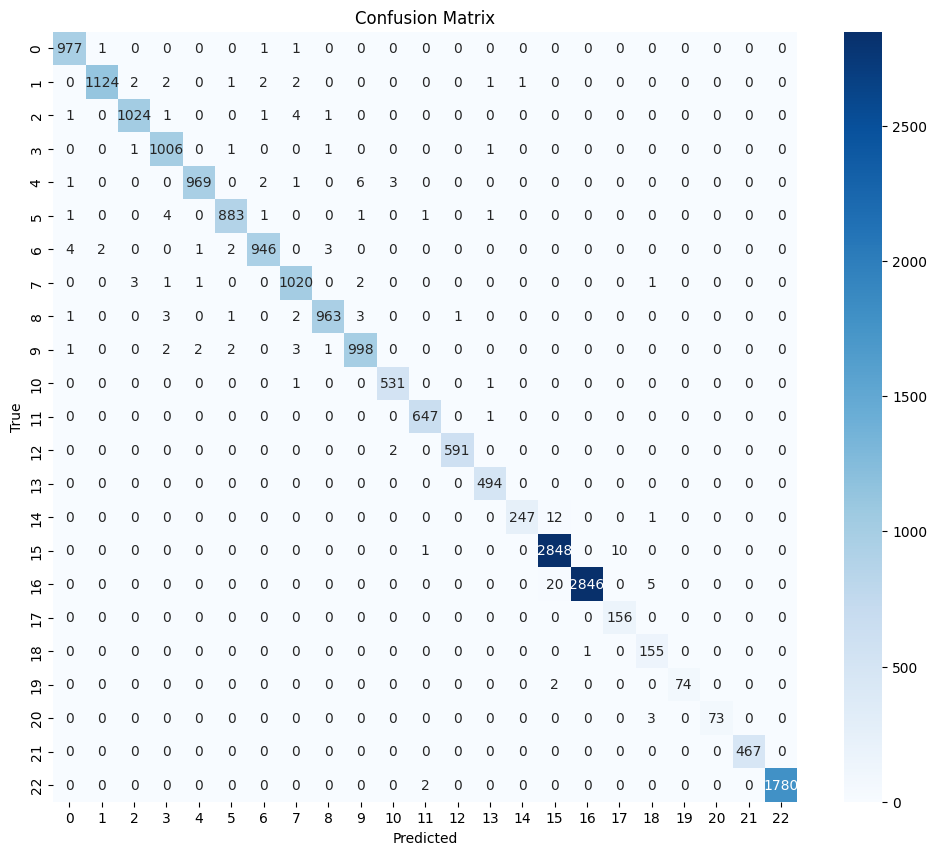

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

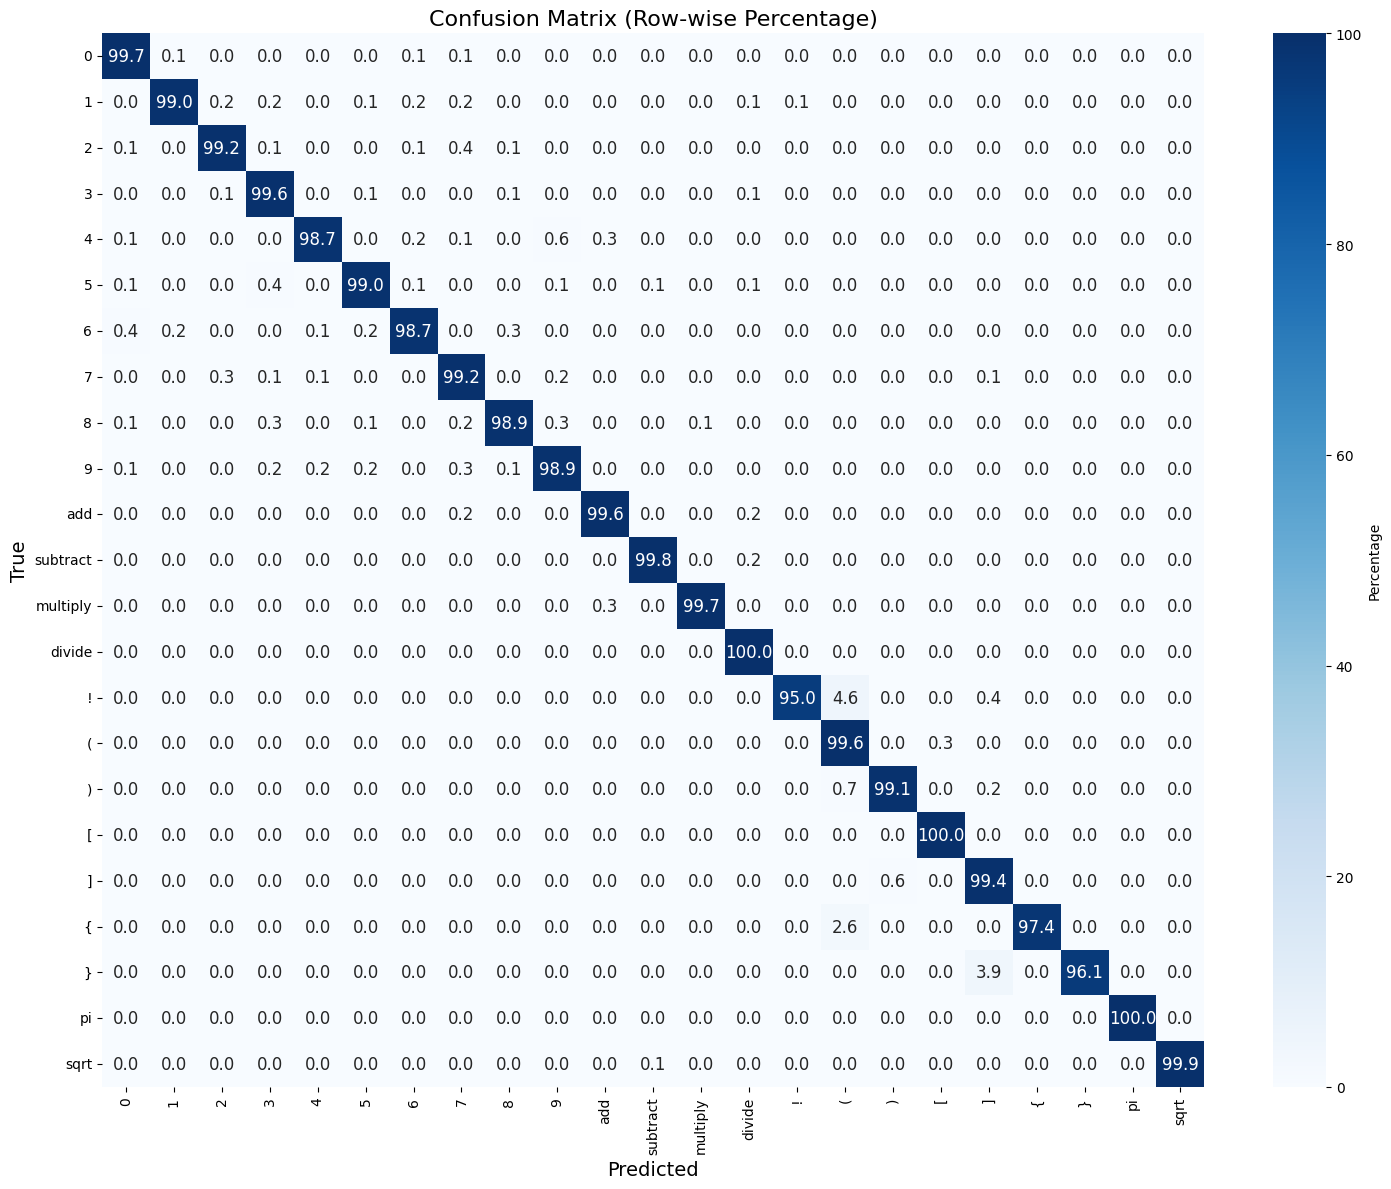

In [26]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize confusion matrix by row (i.e., true classes)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with row-wise percentage values
plt.figure(figsize=(15, 12))  # Increased figure size

# Create heatmap with custom annotation format: 
# '0' as 0, and decimals rounded to one place
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=[str(i) for i in range(10)] + operator_labels, 
            yticklabels=[str(i) for i in range(10)] + operator_labels,
            cbar_kws={'label': 'Percentage'}, annot_kws={"size": 12})  # Adjust font size

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix (Row-wise Percentage)', fontsize=16)
plt.tight_layout()
plt.show()


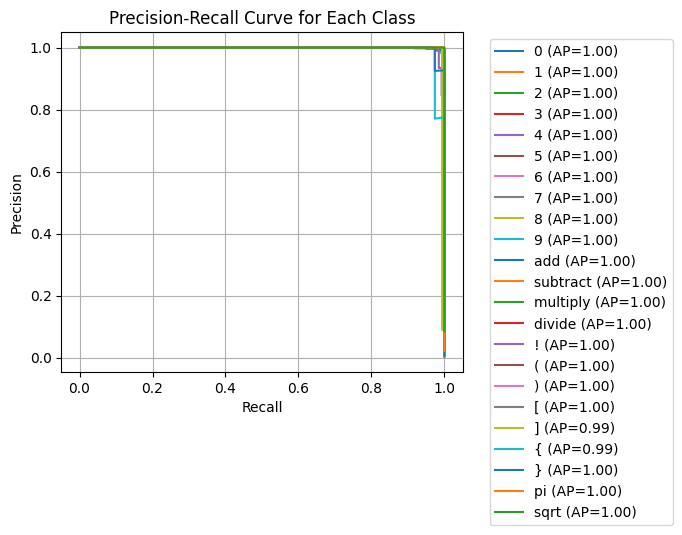

Overall Average Precision (macro-average): 0.9991


In [44]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize true labels
y_true_bin = label_binarize(y_true_classes, classes=list(range(len(operator_labels) + 10)))  # 0–9 + operators

# Plot Precision-Recall Curve per class
plt.figure(figsize=(7, 5))

for i in range(len(y_true_bin[0])):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    ap_score = average_precision_score(y_true_bin[:, i], y_pred[:, i])
    label = (str(i) if i < 10 else operator_labels[i - 10])
    plt.plot(recall, precision, label=f"{label} (AP={ap_score:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

avg_precision = average_precision_score(y_true_bin, y_pred, average='macro')
print(f"Overall Average Precision (macro-average): {avg_precision:.4f}")


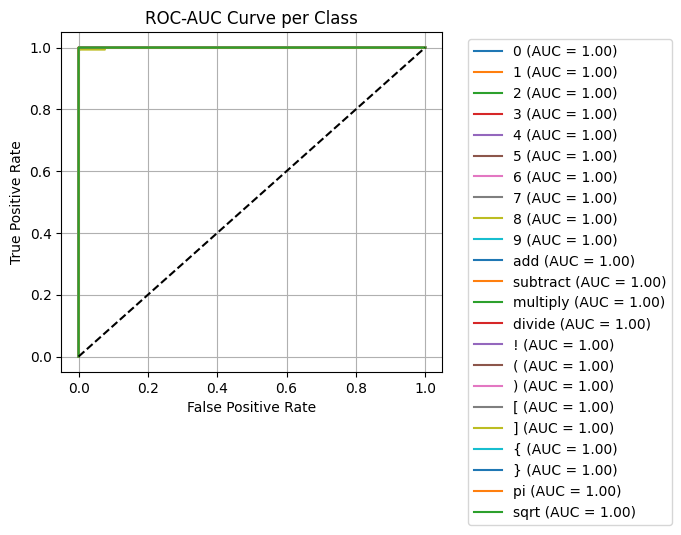

Overall ROC AUC (macro-average): 1.0000


In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(7, 5))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    label = str(i) if i < 10 else operator_labels[i - 10]
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve per Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Compute ROC AUC (macro average)
roc_auc = roc_auc_score(y_true_bin, y_pred, average='macro', multi_class='ovr')
print(f"Overall ROC AUC (macro-average): {roc_auc:.4f}")

In [29]:
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 99.28%
Test Loss: 0.0233


In [30]:
model.save("combined_model.h5")

In [31]:
from tensorflow.keras.models import load_model

# Load the saved model (replace 'your_model.h5' with the path to your model file)
model = load_model('combined_model.h5')

# Display the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 23)                  │           1,495 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,497 (912.10 KB)

 Trainable params: 233,495 (912.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Real time

### Single operator Predict

In [1]:
import cvzone
import cv2
import numpy as np
from cvzone.HandTrackingModule import HandDetector
from tensorflow.keras.models import load_model

# Load the trained operator recognition model
model_path = "combined_model.h5"  # Update this with the actual path
model = load_model(model_path)

# Define operator labels
class_labels = ["0", "1", "2", "3", "4", "5","6", "7" ,"8", "9" ,"add", "subtract", "multiply", "divide", "!", "(", ")", "[", "]", "{", "}", "pi", "sqrt"]

# Initialize Video Capture
cap = cv2.VideoCapture(0)

# Hand Detector
detector = HandDetector(staticMode=False, maxHands=1, modelComplexity=1, detectionCon=0.5, minTrackCon=0.5)

def getHandInfo(img):
    hands, img = detector.findHands(img, draw=True, flipType=True)
    if hands:
        hand = hands[0]  # Get the first detected hand
        lmList = hand["lmList"]  # List of 21 landmarks
        fingers = detector.fingersUp(hand)
        return fingers, lmList
    return None

def draw(info, prev_pos, canvas):
    fingers, lmList = info
    current_pos = None 
    if fingers == [0, 1, 0, 0, 0]:  # Index finger up
        current_pos = lmList[8][0:2]  # Index finger tip coordinates
        if prev_pos is None: 
            prev_pos = current_pos
        cv2.line(canvas, tuple(current_pos), tuple(prev_pos), (255, 255, 255), 10)  # White color for high contrast
    return current_pos, canvas

def preprocess_for_prediction(canvas):
    """ Preprocess the drawn image for model prediction. """
    gray_canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray_canvas, 50, 255, cv2.THRESH_BINARY)
    
    y_indices, x_indices = np.where(binary > 0)
    if len(y_indices) > 0 and len(x_indices) > 0:
        x_min, x_max = x_indices.min(), x_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()
        cropped = binary[y_min:y_max+1, x_min:x_max+1]
    else:
        return None  # No valid drawing detected
    
    # Resize while keeping aspect ratio
    h, w = cropped.shape
    aspect_ratio = w / h

    if aspect_ratio > 1:
        new_w = 20
        new_h = int(20 / aspect_ratio)
    else:
        new_h = 20
        new_w = int(20 * aspect_ratio)

    resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Center in a 28x28 frame
    final_img = np.zeros((28, 28), dtype=np.uint8)
    x_offset = (28 - new_w) // 2
    y_offset = (28 - new_h) // 2
    final_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    # Normalize and reshape for model input
    final_img = final_img / 255.0
    final_img = final_img.reshape(1, 28, 28, 1)

    return final_img

prev_pos = None
canvas = None
predicted_operator = None

while True:
    success, img = cap.read()
    img = cv2.flip(img, 1)  # Mirror effect for a natural drawing experience
    
    if canvas is None:
        canvas = np.zeros_like(img)

    info = getHandInfo(img)
    if info:
        fingers, lmList = info
        
        # Clear canvas when all 5 fingers are up
        if fingers == [1, 1, 1, 1, 1]:  
            canvas = np.zeros_like(img)
            prev_pos = None
            predicted_operator = None
            print("Canvas Cleared (All 5 Fingers Up)")

        # Predict operator when 2nd & 5th fingers are up
        if fingers == [0, 1, 0, 0, 1]:
            processed_img = preprocess_for_prediction(canvas)
            if processed_img is not None:
                prediction = model.predict(processed_img)
                predicted_class = np.argmax(prediction)
                predicted_operator = class_labels[predicted_class]
                confidence = np.max(prediction) * 100
                print(f"Predicted: {predicted_operator} ({confidence:.2f}%)")

        prev_pos, canvas = draw(info, prev_pos, canvas)

    # Overlay canvas on image
    image_combined = cv2.addWeighted(img, 0.7, canvas, 0.3, 0)

    # Display prediction on screen
    if predicted_operator is not None:
        cv2.putText(image_combined, f'Predicted: {predicted_operator}', 
                    (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    
    # Show windows
    cv2.imshow("Canvas", canvas)
    cv2.imshow("Operator Recognition", image_combined)

    # Quit when 'Q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
Canvas Cleared (All 5 Fingers Up)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Predicted: 2 (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted: 2 (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: 2 (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted: 2 (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: 2 (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted: 2 (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: 2 (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: 2 (100.00%)
1

### one by one symbol taking

In [7]:
import cvzone
import cv2
import numpy as np
import math
from cvzone.HandTrackingModule import HandDetector
from tensorflow.keras.models import load_model

# Load model
model = load_model("combined_model.h5")

# Class labels
class_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9",
                "add", "subtract", "multiply", "divide", "!", "(", ")", "[", "]", "{", "}", "pi", "sqrt"]

# Mappings
symbol_map = {
    "add": "+",
    "subtract": "-",
    "multiply": "*",
    "divide": "/",
    "!": "!",
    "(": "(",
    ")": ")",
    "[": "[",
    "]": "]",
    "{": "{",
    "}": "}",
    "pi": "math.pi",
    "sqrt": "math.sqrt"
}

# Init
cap = cv2.VideoCapture(0)
detector = HandDetector(staticMode=False, maxHands=1, modelComplexity=1, detectionCon=0.5, minTrackCon=0.5)

prev_pos = None
canvas = None
predicted_operator = None
expression = ""
result = ""

# Functions
def getHandInfo(img):
    hands, img = detector.findHands(img, draw=True, flipType=True)
    if hands:
        hand = hands[0]
        lmList = hand["lmList"]
        fingers = detector.fingersUp(hand)
        return fingers, lmList
    return None

def draw(info, prev_pos, canvas):
    fingers, lmList = info
    current_pos = None 
    if fingers == [0, 1, 0, 0, 0]:  # Only index up
        current_pos = lmList[8][0:2]
        if prev_pos is None:
            prev_pos = current_pos
        cv2.line(canvas, tuple(current_pos), tuple(prev_pos), (255, 255, 255), 10)
    return current_pos, canvas

def preprocess_for_prediction(canvas):
    gray = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    y_indices, x_indices = np.where(binary > 0)
    if len(y_indices) > 0 and len(x_indices) > 0:
        x_min, x_max = x_indices.min(), x_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()
        cropped = binary[y_min:y_max+1, x_min:x_max+1]
    else:
        return None

    h, w = cropped.shape
    aspect_ratio = w / h
    if aspect_ratio > 1:
        new_w = 20
        new_h = int(20 / aspect_ratio)
    else:
        new_h = 20
        new_w = int(20 * aspect_ratio)

    resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)
    final_img = np.zeros((28, 28), dtype=np.uint8)
    x_offset = (28 - new_w) // 2
    y_offset = (28 - new_h) // 2
    final_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    final_img = final_img / 255.0
    return final_img.reshape(1, 28, 28, 1)

def evaluate_expression(expression):
    """ Evaluates the expression safely, replacing '!' with math.factorial."""
    # Replace factorial symbol '!' with math.factorial function call
    expression = expression.replace("!", "math.factorial")

    # Safe evaluation using math functions and pi/sqrt
    try:
        # Add math module and constants like pi and sqrt for safe eval
        result = eval(expression, {"__builtins__": None}, {"math": math, "pi": math.pi, "sqrt": math.sqrt})
        return result
    except Exception as e:
        return f"Error: {str(e)}"

while True:
    success, img = cap.read()
    img = cv2.flip(img, 1)
    
    if canvas is None:
        canvas = np.zeros_like(img)

    info = getHandInfo(img)
    if info:
        fingers, lmList = info

        # Clear canvas & expression
        if fingers == [1, 1, 1, 1, 1]:
            canvas = np.zeros_like(img)
            prev_pos = None
            predicted_operator = None
            expression = ""
            result = ""
            print("Canvas & Expression Cleared")

        # Predict on 2nd & 5th fingers
        if fingers == [0, 1, 0, 0, 1]:
            processed_img = preprocess_for_prediction(canvas)
            if processed_img is not None:
                prediction = model.predict(processed_img)
                predicted_class = np.argmax(prediction)
                predicted_label = class_labels[predicted_class]
                predicted_operator = predicted_label
                symbol = symbol_map.get(predicted_label, predicted_label)
                expression += symbol
                print("Added:", symbol)
            canvas = np.zeros_like(img)
            prev_pos = None

        # Evaluate on all 4 fingers up
        if fingers == [0, 1, 1, 1, 1] and expression != "":
            result = evaluate_expression(expression)
            print("Evaluated:", result)

        # Remove last symbol if only pinky is up, and it's not already processed
        if fingers == [0, 0, 0, 0, 1] and expression != "":
            if not symbol_removed:
                removed_symbol = expression[-1]
                expression = expression[:-1]
                predicted_operator = None
                symbol_removed = True
                print(f"Removed last symbol: {removed_symbol}")
        else:
            symbol_removed = False  # Reset when pinky is not up


        prev_pos, canvas = draw(info, prev_pos, canvas)

    combined = cv2.addWeighted(img, 0.7, canvas, 0.3, 0)

    # Display predictions and results
    if predicted_operator:
        cv2.putText(combined, f'Predicted: {predicted_operator}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,255,0), 3)
    if expression:
        cv2.putText(combined, f'Expression: {expression}', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,0), 3)
    if result:
        cv2.putText(combined, f'Result: {result}', (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,255), 3)

    cv2.imshow("Canvas", canvas)
    cv2.imshow("Air Math", combined)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Canvas & Expression Cleared
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Added: 6
Removed last symbol: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Added: 6
Removed last symbol: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Added: (
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Added: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Added: +
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Added: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Added: 1
Removed last symbol: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Added: 3
Removed last symbol: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Added: 1
Removed last symbol: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Added: )
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Added: *
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Added: math.sqrt
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Added: (
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Added: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Added: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Added: 7
Removed last symbol: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Added: 1
Removed last symbol: 1
1/1 